<a href="https://colab.research.google.com/github/engantung/ComputerVision/blob/master/CVProject_04_ImageReconstruction_Multiple_BOLD_NII_to_JPEG_Processing_with_Lower_Train_Size_with_MLP_Regressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python -V

Python 3.6.9


In [ ]:
###################### Only if you use Google Colab ############################
###################### B E G I N Google Colab Code #############################
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%cd /content/drive/My\ Drive/SUMMER\ Project\ 2020/RB_Course/Final_Project/Image_Reconstruction/

/content/drive/My Drive/SUMMER Project 2020/RB_Course/Final_Project/Image_Reconstruction


In [ ]:
!ls

bp_images  Readme.txt  result_images  stimulus_images  tsv_images


In [ ]:
import sys
sys.path.append('content/drive/My Drive/SUMMER Project 2020//RB_Course/Final_Project/Image_Reconstruction/')

In [ ]:
"""
Created on August 2020

@author: 
    Edmond Hendrik Jacob Ngantung
  
"""

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import nibabel as nib 
import pandas as pd
from skimage.io import imread

import glob
import cv2
import os
import matplotlib.gridspec as gridspec

from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn.random_projection import GaussianRandomProjection
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.kernel_approximation import RBFSampler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor

In [ ]:
def train_display(regressor, image_input1, image_input2, image_target, TTS_training_size, TTS_random_state):
    height, width = image_target.shape
    
    flat_image_input1 = np.reshape(image_input1,-1)
    flat_image_input2 = np.reshape(image_input2,-1)
    flat_image_target = np.reshape(image_target,-1)
    #flat_image_input1 = image_input1.reshape(-1)
    #flat_image_input2 = image_input2.reshape(-1)
    #flat_image_target = image_target.reshape(-1)
    
    #xs = np.arange(len(flat_image_input1)) % width
    xs = flat_image_input1
    #ys = np.arange(len(flat_image_input2)) // width 
    ys = flat_image_input2
     
    data = np.array([xs, ys]).T
    target = flat_image_target
    
    trainX, testX, trainY, testY = train_test_split(data, target, train_size=TTS_training_size, random_state=TTS_random_state)
    #trainX, testX, trainY, testY = train_test_split(data, target, train_size, random_state=42)
    mean = trainY.mean()
    regressor.fit(trainX, trainY - mean)
    new_flat_picture = regressor.predict(data) + mean
    plt.imshow(new_flat_picture.reshape(height, width), cmap='gray')

    return new_flat_picture

In [ ]:
def image_loader(Image_Path):
    paths = glob.glob(os.path.join(Image_Path, "*.jpeg"))
    paths.sort(key=lambda x:str(x[:-6])) # this part is depending on the type of file.
    image_list = []
    for i in range(len(paths)):
        temp_img = cv2.imread(paths[i])
        image_list.append(temp_img)
        
    return image_list 

In [ ]:
def tight_plot(img,count):
    plt.figure(figsize=(20, 20))   # change depends on the numbers of images
    gs1 = gridspec.GridSpec(5, round(count/5))
    gs1.update(wspace=0, hspace=0)
    for i in range(len(img)):
        ax = plt.subplot(gs1[i])
        ax.imshow(img[i])
        plt.axis('off')
        plt.subplots_adjust(wspace=0, hspace=0)
        #ax.set_title(str(i))
        ax.text(0.1,0.9,str(i),c="red",fontsize=16,ha='center', va='center', transform=ax.transAxes)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    plt.show()
    plt.savefig('result_images/natural_results/result_reconstruction.jpeg')    # save is you want to

In [ ]:
def img_remove_white_edge(img_list):
    new_img_list = []
    for i in range(len(img_list)):
        temp_img = img_list[i]
        image = Image.fromarray(cv2.cvtColor(temp_img,cv2.COLOR_BGR2RGB))
        ivt_image = ImageOps.invert(image)
        bbox = ivt_image.getbbox()
        padding=(0, 0, 0, 0)
        left = bbox[0] - padding[0]
        top = bbox[1] - padding[1]
        right = bbox[2] + padding[2]
        bottom = bbox[3] + padding[3]
        cropped_image = image.crop([left, top, right, bottom]) 
        recover_img = cv2.cvtColor(np.array(cropped_image),cv2.COLOR_RGB2BGR)
        recover_img = cv2.resize(recover_img, (500,500))
        filter_img = cv2.bilateralFilter(src=recover_img, d=0, sigmaColor=100, sigmaSpace=10)
        new_img_list.append(filter_img)
    
    return new_img_list

In [ ]:
def image_reconstruction(img_input_to_reconstruct, img_input, img_target, images_combined, count, trainsize, randomstate, 
                         mlplayers, mlpactivator, mlpalgo, mlplearningrate, mlpalpha, mlpbatchsize, mlplearningratetype, 
                         mlppower, mlpiteration, mlpshuffle, mlprandomstate, mlptolerance, mlpverbose, mlpwarmstart, mlpmomentum, 
                         mlpnesterovmomentum, mlpstopping, mlpvalidationvalue, mlpbeta1, mlpbeta2, mlpepsilon, mlpiternochange, mlpnumfun):
  
    img_input_to_reconstruct =  train_display(MLPRegressor(hidden_layer_sizes=mlplayers, 
                                              activation=mlpactivator, 
                                              solver=mlpalgo, 
                                              alpha=mlpalpha, 
                                              batch_size=mlpbatchsize, 
                                              learning_rate=mlplearningratetype, 
                                              learning_rate_init=mlplearningrate, 
                                              power_t=mlppower, 
                                              max_iter=mlpiteration, 
                                              shuffle=mlpshuffle, 
                                              random_state=mlprandomstate, 
                                              tol=mlptolerance, 
                                              verbose=mlpverbose, 
                                              warm_start=mlpwarmstart, 
                                              momentum=mlpmomentum, 
                                              nesterovs_momentum=mlpnesterovmomentum, 
                                              early_stopping=mlpstopping, 
                                              validation_fraction=mlpvalidationvalue, 
                                              beta_1=mlpbeta1, 
                                              beta_2=mlpbeta2, 
                                              epsilon=mlpepsilon, 
                                              n_iter_no_change=mlpiternochange, 
                                              max_fun=mlpnumfun),
                                              img_input_to_reconstruct, img_input, img_target, trainsize, randomstate)

    for i in np.arange(3,count-35):
        IMAG_input_train_image = images_combined[:,:,i,:]
        plt.imshow(IMAG_input_train_image.astype(np.uint8))
        plt.axis("off")
        plt.savefig('result_images/natural_results/training_images/input_train_image'+str(i)+'.jpeg')
        
        opened_input_train_image = Image.open('result_images/natural_results/training_images/input_train_image'+str(i)+'.jpeg')
        resize_input_train_image = opened_input_train_image.resize((500, 500))
        resize_input_train_image.save('result_images/natural_results/training_images/input_train_image'+str(i)+'_500x500.jpeg')
        img_train_input = np.asarray(Image.open('result_images/natural_results/training_images/input_train_image'+str(i)+'_500x500.jpeg')).mean(axis=2)

        img_input_to_reconstruct =  train_display(MLPRegressor(hidden_layer_sizes=mlplayers, 
                                                  activation=mlpactivator, 
                                                  solver=mlpalgo, 
                                                  alpha=mlpalpha, 
                                                  batch_size=mlpbatchsize, 
                                                  learning_rate=mlplearningratetype, 
                                                  learning_rate_init=mlplearningrate, 
                                                  power_t=mlppower, 
                                                  max_iter=mlpiteration, 
                                                  shuffle=mlpshuffle, 
                                                  random_state=mlprandomstate, 
                                                  tol=mlptolerance, 
                                                  verbose=mlpverbose, 
                                                  warm_start=mlpwarmstart, 
                                                  momentum=mlpmomentum, 
                                                  nesterovs_momentum=mlpnesterovmomentum, 
                                                  early_stopping=mlpstopping, 
                                                  validation_fraction=mlpvalidationvalue, 
                                                  beta_1=mlpbeta1, 
                                                  beta_2=mlpbeta2, 
                                                  epsilon=mlpepsilon, 
                                                  n_iter_no_change=mlpiternochange, 
                                                  max_fun=mlpnumfun),
                                                  img_input_to_reconstruct, img_train_input, img_target, trainsize, randomstate)

        plt.axis("off")
        plt.savefig('result_images/natural_results/reconstructed_images/reconstruction-'+str(10+(i-2)) +'.jpeg')
        print("Trained and Reconstructed Image - ", i-2)
    return img_input_to_reconstruct 

In [ ]:
def nii_to_image(nii,nimg,evts):
    stimtimes = evts[1:-1,0] # exclude first and last (times)
    stim_names = evts[1:-1,4] # exclude first and last (image names)
    trs = (stimtimes/2).astype(int) # because TR = 2 sec
    #print("Total Images created: ", trs.shape[0])
    avgstims = np.zeros([nii.shape[0],nii.shape[1],nii.shape[2],trs.shape[0]])
    images = np.zeros([500,500,trs.shape[0],3])
    #print("IMAGES Shape: ", images.shape)
    print("")
    count = 0
    for i in np.arange(0,trs.shape[0]):
        #convert 4d to 3d 
        avgstims[:,:,:,i] = np.mean(nimg[:,:,:,trs[i]+2:trs[i]+6],axis=3)
        #print(" Bold Image Chosen -", i, ": ", avgstims[:,:,:,i].shape)
        count = count + 1
        images[:,:,i,:] = imread('stimulus_images/stimulus_NaturalImageTrain/'+stim_names[i]+'.JPEG')
    return avgstims, images, count

In [ ]:
#DATA PREPARATION        
nii = nib.load('bp_images/ses_natural_image_train/bp_NaturalImageTraining01_func_sub-01_run-01_bold.nii.gz')
nii_02 = nib.load('bp_images/ses_natural_image_train/bp_NaturalImageTraining01_func_sub-01_run-02_bold.nii.gz')
nii_03 = nib.load('bp_images/ses_natural_image_train/bp_NaturalImageTraining06_func_sub-01_run-01_bold.nii.gz')
nii_04 = nib.load('bp_images/ses_natural_image_train/bp_NaturalImageTraining02_func_sub-01_run-03_bold.nii.gz')
nii_05 = nib.load('bp_images/ses_natural_image_train/bp_NaturalImageTraining02_func_sub-01_run-07_bold.nii.gz')
nii_06 = nib.load('bp_images/ses_natural_image_train/bp_NaturalImageTraining03_func_sub-01_run-04_bold.nii.gz')
nii_07 = nib.load('bp_images/ses_natural_image_train/bp_NaturalImageTraining03_func_sub-01_run-08_bold.nii.gz')

'''
nii_08 = nib.load('bp_images/ses_natural_image_train/bp_NaturalImageTraining04_func_sub-01_run-03_bold.nii.gz')
nii_09 = nib.load('bp_images/ses_natural_image_train/bp_NaturalImageTraining04_func_sub-01_run-06_bold.nii.gz')
nii_10 = nib.load('bp_images/ses_natural_image_train/bp_NaturalImageTraining05_func_sub-01_run-01_bold.nii.gz')
nii_11 = nib.load('bp_images/ses_natural_image_train/bp_NaturalImageTraining05_func_sub-01_run-08_bold.nii.gz')
nii_12 = nib.load('bp_images/ses_natural_image_train/bp_NaturalImageTraining06_func_sub-01_run-06_bold.nii.gz')
nii_13 = nib.load('bp_images/ses_natural_image_train/bp_NaturalImageTraining07_func_sub-01_run-02_bold.nii.gz')
nii_14 = nib.load('bp_images/ses_natural_image_train/bp_NaturalImageTraining07_func_sub-01_run-04_bold.nii.gz')
'''

nimg = nii.get_data()
nimg_02 = nii_02.get_data()
nimg_03 = nii_03.get_data()
nimg_04 = nii_04.get_data()
nimg_05 = nii_05.get_data()
nimg_06 = nii_06.get_data()
nimg_07 = nii_07.get_data()

'''
nimg_08 = nii_08.get_data()
nimg_09 = nii_09.get_data()
nimg_10 = nii_10.get_data()
nimg_11 = nii_11.get_data()
nimg_12 = nii_12.get_data()
nimg_13 = nii_13.get_data()
nimg_14 = nii_14.get_data()
'''

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.datao

'\nnimg_08 = nii_08.get_data()\nnimg_09 = nii_09.get_data()\nnimg_10 = nii_10.get_data()\nnimg_11 = nii_11.get_data()\nnimg_12 = nii_12.get_data()\nnimg_13 = nii_13.get_data()\nnimg_14 = nii_14.get_data()\n'

In [ ]:
evts = pd.read_csv('tsv_images/NaturalImageTrain/Events_NaturalImageTraining01_func_sub-01_run-01_events.tsv',sep='\t')
evts_02 = pd.read_csv('tsv_images/NaturalImageTrain/Events_NaturalImageTraining01_func_sub-01_run-02_events.tsv',sep='\t')
evts_03 = pd.read_csv('tsv_images/NaturalImageTrain/Events_NaturalImageTraining06_func_sub-01_run-01_events.tsv',sep='\t')
evts_04 = pd.read_csv('tsv_images/NaturalImageTrain/Events_NaturalImageTraining02_func_sub-01_run-03_events.tsv',sep='\t')
evts_05 = pd.read_csv('tsv_images/NaturalImageTrain/Events_NaturalImageTraining02_func_sub-01_run-07_events.tsv',sep='\t')
evts_06 = pd.read_csv('tsv_images/NaturalImageTrain/Events_NaturalImageTraining03_func_sub-01_run-04_events.tsv',sep='\t')
evts_07 = pd.read_csv('tsv_images/NaturalImageTrain/Events_NaturalImageTraining03_func_sub-01_run-08_events.tsv',sep='\t')
'''
evts_08 = pd.read_csv('tsv_images/NaturalImageTrain/Events_NaturalImageTraining04_func_sub-01_run-03_events.tsv',sep='\t')
evts_09 = pd.read_csv('tsv_images/NaturalImageTrain/Events_NaturalImageTraining04_func_sub-01_run-06_events.tsv',sep='\t')
evts_10 = pd.read_csv('tsv_images/NaturalImageTrain/Events_NaturalImageTraining05_func_sub-01_run-01_events.tsv',sep='\t')
evts_11 = pd.read_csv('tsv_images/NaturalImageTrain/Events_NaturalImageTraining05_func_sub-01_run-08_events.tsv',sep='\t')
evts_12 = pd.read_csv('tsv_images/NaturalImageTrain/Events_NaturalImageTraining06_func_sub-01_run-06_events.tsv',sep='\t')
evts_13 = pd.read_csv('tsv_images/NaturalImageTrain/Events_NaturalImageTraining07_func_sub-01_run-02_events.tsv',sep='\t')
evts_14 = pd.read_csv('tsv_images/NaturalImageTrain/Events_NaturalImageTraining07_func_sub-01_run-04_events.tsv',sep='\t')
'''

evts = np.asarray(evts)
evts_02 = np.asarray(evts_02)
evts_03 = np.asarray(evts_03)
evts_04 = np.asarray(evts_04)
evts_05 = np.asarray(evts_05)
evts_06 = np.asarray(evts_06)
evts_07 = np.asarray(evts_07)
'''
evts_08 = np.asarray(evts_08)
evts_09 = np.asarray(evts_09)
evts_10 = np.asarray(evts_10)
evts_11 = np.asarray(evts_11)
evts_12 = np.asarray(evts_12)
evts_13 = np.asarray(evts_13)
evts_14 = np.asarray(evts_14)
'''

'\nevts_08 = np.asarray(evts_08)\nevts_09 = np.asarray(evts_09)\nevts_10 = np.asarray(evts_10)\nevts_11 = np.asarray(evts_11)\nevts_12 = np.asarray(evts_12)\nevts_13 = np.asarray(evts_13)\nevts_14 = np.asarray(evts_14)\n'

In [ ]:
#THE LIST ALL OF IMAGES SEEN FOLLOWING WITH THE BRAIN IMAGES 
avgstims, images, count = nii_to_image(nii,nimg,evts)
avgstims_02, images_02, count_02 = nii_to_image(nii_02,nimg_02,evts_02)
avgstims_03, images_03, count_03 = nii_to_image(nii_03,nimg_03,evts_03)
avgstims_04, images_04, count_04 = nii_to_image(nii_04,nimg_04,evts_04)
avgstims_05, images_05, count_05 = nii_to_image(nii_05,nimg_05,evts_05)
avgstims_06, images_06, count_06 = nii_to_image(nii_06,nimg_06,evts_06)
avgstims_07, images_07, count_07 = nii_to_image(nii_07,nimg_07,evts_07)
'''
avgstims_08, images_08, count_08 = nii_to_image(nii_08,nimg_08,evts_08)
avgstims_09, images_09, count_09 = nii_to_image(nii_09,nimg_09,evts_09)
avgstims_10, images_10, count_10 = nii_to_image(nii_10,nimg_10,evts_10)
avgstims_11, images_11, count_11 = nii_to_image(nii_11,nimg_11,evts_11)
avgstims_12, images_12, count_12 = nii_to_image(nii_12,nimg_12,evts_12)
avgstims_13, images_13, count_13 = nii_to_image(nii_13,nimg_13,evts_13)
avgstims_14, images_14, count_14 = nii_to_image(nii_14,nimg_14,evts_14)
'''

'\navgstims_08, images_08, count_08 = nii_to_image(nii_08,nimg_08,evts_08)\navgstims_09, images_09, count_09 = nii_to_image(nii_09,nimg_09,evts_09)\navgstims_10, images_10, count_10 = nii_to_image(nii_10,nimg_10,evts_10)\navgstims_11, images_11, count_11 = nii_to_image(nii_11,nimg_11,evts_11)\navgstims_12, images_12, count_12 = nii_to_image(nii_12,nimg_12,evts_12)\navgstims_13, images_13, count_13 = nii_to_image(nii_13,nimg_13,evts_13)\navgstims_14, images_14, count_14 = nii_to_image(nii_14,nimg_14,evts_14)\n'

In [ ]:
num_images_per_bp_image = count
print("Total Counter : ",num_images_per_bp_image)
images_combined = np.zeros([500,500,num_images_per_bp_image*7,3])

Total Counter :  55


In [ ]:
count = 0
for i in np.arange(0,num_images_per_bp_image):
    images_combined[:,:,i,:] = images[:,:,i,:]
    count = count + 1
    images_combined[:,:,i+1*num_images_per_bp_image,:] = images_02[:,:,i,:]
    count = count + 1
    images_combined[:,:,i+2*num_images_per_bp_image,:] = images_03[:,:,i,:]
    count = count + 1
    images_combined[:,:,i+3*num_images_per_bp_image,:] = images_04[:,:,i,:]
    count = count + 1
    images_combined[:,:,i+4*num_images_per_bp_image,:] = images_05[:,:,i,:]
    count = count + 1
    images_combined[:,:,i+5*num_images_per_bp_image,:] = images_06[:,:,i,:]
    count = count + 1
    images_combined[:,:,i+6*num_images_per_bp_image,:] = images_07[:,:,i,:]
    count = count + 1
    '''
    images_combined[:,:,i+7*num_images_per_bp_image,:] = images_08[:,:,i,:]
    count = count + 1
    images_combined[:,:,i+8*num_images_per_bp_image,:] = images_09[:,:,i,:]
    count = count + 1
    images_combined[:,:,i+9*num_images_per_bp_image,:] = images_10[:,:,i,:]
    count = count + 1
    images_combined[:,:,i+10*num_images_per_bp_image,:] = images_11[:,:,i,:]
    count = count + 1
    images_combined[:,:,i+11*num_images_per_bp_image,:] = images_12[:,:,i,:]
    count = count + 1
    images_combined[:,:,i+12*num_images_per_bp_image,:] = images_13[:,:,i,:]
    count = count + 1
    images_combined[:,:,i+13*num_images_per_bp_image,:] = images_14[:,:,i,:]
    count = count + 1
    '''
print("Total Count = " , count)

Total Count =  385


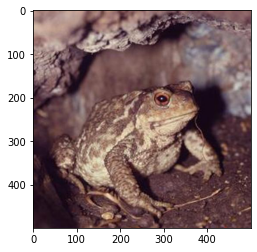

In [ ]:
#Testing Image Target
IMAG_frog = images_combined[:,:,0,:]
plt.imshow(IMAG_frog.astype(np.uint8)) #-> example picture for single slice 

1  out of  385  Seen Images Stored 
2  out of  385  Seen Images Stored 
3  out of  385  Seen Images Stored 
4  out of  385  Seen Images Stored 
5  out of  385  Seen Images Stored 
6  out of  385  Seen Images Stored 
7  out of  385  Seen Images Stored 
8  out of  385  Seen Images Stored 
9  out of  385  Seen Images Stored 
10  out of  385  Seen Images Stored 
11  out of  385  Seen Images Stored 
12  out of  385  Seen Images Stored 
13  out of  385  Seen Images Stored 
14  out of  385  Seen Images Stored 
15  out of  385  Seen Images Stored 
16  out of  385  Seen Images Stored 
17  out of  385  Seen Images Stored 
18  out of  385  Seen Images Stored 
19  out of  385  Seen Images Stored 
20  out of  385  Seen Images Stored 
21  out of  385  Seen Images Stored 
22  out of  385  Seen Images Stored 
23  out of  385  Seen Images Stored 
24  out of  385  Seen Images Stored 
25  out of  385  Seen Images Stored 
26  out of  385  Seen Images Stored 
27  out of  385  Seen Images Stored 
28  out of

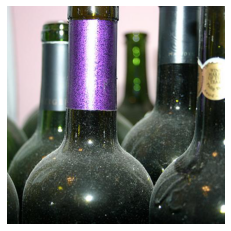

In [ ]:
# also show how to trim brain
for i in np.arange(0,count):
    plt.imshow(images_combined[:,:,i,:].astype(np.uint8))
    plt.axis("off")
    plt.savefig('result_images/natural_results/list_image_seen/image_seen-'+str(10+(i)) +'.jpeg')
    print(i+1," out of ",count," Seen Images Stored ") 
    #plt.imshow(avgstims[:,:,32,i].astype(np.uint8))
    #plt.imshow(avgstims[:,:,32,i])

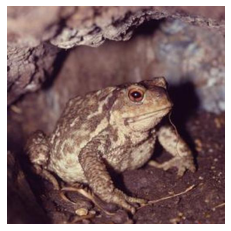

In [ ]:
#FIRST TRIAL TRAINING
IMAG_input_image0 = images_combined[:,:,1,:]
plt.imshow(IMAG_input_image0.astype(np.uint8))
plt.axis("off")
plt.savefig('result_images/natural_results/training_images/input_training_image0.jpeg')
opened_input_image0 = Image.open('result_images/natural_results/training_images/input_training_image0.jpeg')
resize_input_image0 = opened_input_image0.resize((500, 500))
resize_input_image0.save('result_images/natural_results/training_images/input_training_image0_500x500.jpeg')
img_input_0 = np.asarray(Image.open('result_images/natural_results/training_images/input_training_image0_500x500.jpeg')).mean(axis=2)

IMAG_input_image = images_combined[:,:,2,:]
plt.imshow(IMAG_input_image.astype(np.uint8))
plt.axis("off")
plt.savefig('result_images/natural_results/training_images/input_training_image.jpeg')
opened_input_image = Image.open('result_images/natural_results/training_images/input_training_image.jpeg')
resize_input_image = opened_input_image.resize((500, 500))
resize_input_image.save('result_images/natural_results/training_images/input_training_image_500x500.jpeg')
img_input = np.asarray(Image.open('result_images/natural_results/training_images/input_training_image_500x500.jpeg')).mean(axis=2)

IMAG_target = images_combined[:,:,0,:]
plt.imshow(IMAG_target.astype(np.uint8))
plt.axis("off")
plt.savefig('result_images/natural_results/target_image/target_image.jpeg')
opened_img_target = Image.open('result_images/natural_results/target_image/target_image.jpeg')
resize_img_target = opened_img_target.resize((500, 500))
resize_img_target.save('result_images/natural_results/target_image/target_image_500x500.jpeg')
img_target = np.asarray(Image.open('result_images/natural_results/target_image/target_image_500x500.jpeg')).mean(axis=2)

In [ ]:
#MAIN FUNCTION PROCESS OVERVIEW 
if __name__ == '__main__':
    initial_image = img_input
    target_picture = img_target
    image_to_reconstruct = img_input_0
    list_images = images_combined
    number_of_train = count
    
    #PARAMETERS
    #Train Test Split Parameters
    Train_Test_Split_train_size = 0.08
    Train_Test_Split_random_state = 42
    
    #Multi Layer Perceptron (MLP) Parameters
    MLP_Layers = (100, 100, 100, )
    MLP_Activator = 'relu'
    MLP_Algorithm_Type = 'adam'
    MLP_Learning_Rate = 0.001
    MLP_Alpha_Rate = 0.0001
    MLP_Batch_Size = 'auto'
    MLP_Learning_Type = 'constant'
    MLP_PowerT = 0.5
    MLP_Iteration = 1000
    MLP_Shuffle = True
    MLP_Random_State = None
    MLP_Tolerance = 0.0001
    MLP_Verbose = False
    MLP_Warm_Start = False
    MLP_Momentum = 0.9
    MLP_Nesterov_Momentum = True
    MLP_Early_Stopping = False
    MLP_Validation_Value = 0.1
    MLP_Beta01 = 0.9
    MLP_Beta02 = 0.999
    MLP_Epsilon = 1e-08
    MLP_Num_Iteration_No_Change = 10
    MLP_Num_Function_Calls = 15000

    #Apply Machine Learning, Training and Image Reconstruction
    
    #Method used for Machine Learning : Neural Network - Multi Layer Perceptron (MLP)
    image_reconstruction(image_to_reconstruct, initial_image, target_picture, list_images, number_of_train, Train_Test_Split_train_size, Train_Test_Split_random_state, 
                         MLP_Layers, MLP_Activator, MLP_Algorithm_Type, MLP_Learning_Rate, MLP_Alpha_Rate, MLP_Batch_Size, MLP_Learning_Type, 
                         MLP_PowerT, MLP_Iteration, MLP_Shuffle, MLP_Random_State, MLP_Tolerance, MLP_Verbose, MLP_Warm_Start, MLP_Momentum, 
                         MLP_Nesterov_Momentum, MLP_Early_Stopping, MLP_Validation_Value, MLP_Beta01, MLP_Beta02, MLP_Epsilon, MLP_Num_Iteration_No_Change, MLP_Num_Function_Calls)


    Show_Image_Reconstruction = "result_images/natural_results/reconstructed_images/"
    image_array_list = image_loader(Show_Image_Reconstruction)
    new_img = img_remove_white_edge(image_array_list)
    tight_plot(new_img,count)

In [ ]:
#LIST OF MACHINE LEARNING CHOICES#
    
#train_display(LinearRegression(), image)
#train_display(DecisionTreeRegressor(max_depth=10), image)
#train_display(DecisionTreeRegressor(max_depth=20), image)
#train_display(DecisionTreeRegressor(min_samples_leaf=40), image)
#train_display(DecisionTreeRegressor(min_samples_leaf=5), image)
#train_display(RandomForestRegressor(n_estimators=100), image)
#train_display(KNeighborsRegressor(n_neighbors=2), image)
#train_display(KNeighborsRegressor(n_neighbors=5, weights='distance'), image)
#train_display(KNeighborsRegressor(n_neighbors=25, weights='distance'), image)
#train_display(KNeighborsRegressor(n_neighbors=2, metric='canberra'), image)
#train_display(XGBoostRegressor(max_depth=5, n_estimators=100, subsample=0.5, nthreads=4), img_input1, img_input2, img_target)
#train_display(XGBoostRegressor(max_depth=12, n_estimators=100, subsample=0.5, nthreads=4, eta=0.1), img_input1, img_input2, img_target)

#train_display(TheanetsRegressor(layers=[20, 20], hidden_activation='tanh', 
#                                trainers=[{'algo': 'adadelta', 'learning_rate': 0.01}]), img_input1, img_input2, img_target)

#train_display(TheanetsRegressor(layers=[40, 40, 40, 40], hidden_activation='tanh', 
#                                trainers=[{'algo': 'adadelta', 'learning_rate': 0.01}]), img_input1, img_input2, img_target)


#base = make_pipeline(GaussianRandomProjection(n_components=10), 
#                     DecisionTreeRegressor(max_depth=10, max_features=5))
#train_display(AdaBoostRegressor(base, n_estimators=50, learning_rate=0.05), img_input1, img_input2, img_target)

#
#base = make_pipeline(GaussianRandomProjection(n_components=15), 
#                     DecisionTreeRegressor(max_depth=12, max_features=5))
#train_display(BaggingRegressor(base, n_estimators=100), img_input1, img_input2, img_target)
